In [1]:
from os.path import join, expanduser
DATA_ROOT = '/Users/victorialin/Documents/2019-2020/11-785/Final Project/data/cmu_arctic/'

In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 300 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [4]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [5]:
bdl_source = MyFileDataSource(data_root=DATA_ROOT,
                              speakers=["bdl"], max_files=max_files)
ksp_source = MyFileDataSource(data_root=DATA_ROOT,
                              speakers=["ksp"], max_files=max_files)

In [6]:
X = PaddedFileSourceDataset(ksp_source, 1200).asarray()
Y = PaddedFileSourceDataset(bdl_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(291, 1200, 25)
(291, 1200, 25)


In [7]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

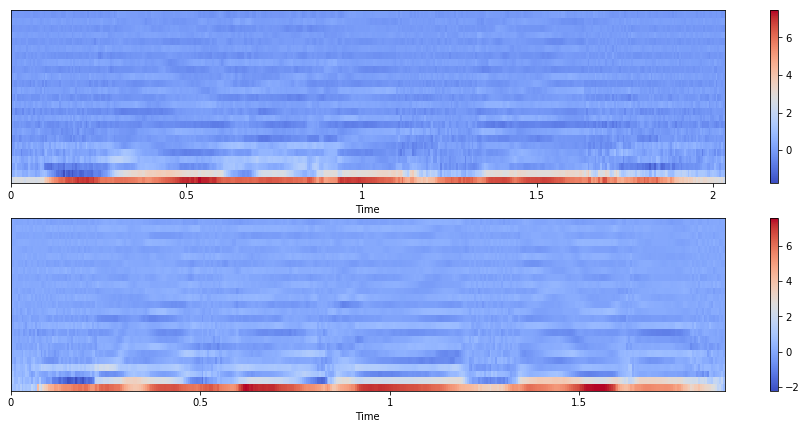

In [8]:
idx = 22 # any
plot_parallel(X[idx],Y[idx])

In [9]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

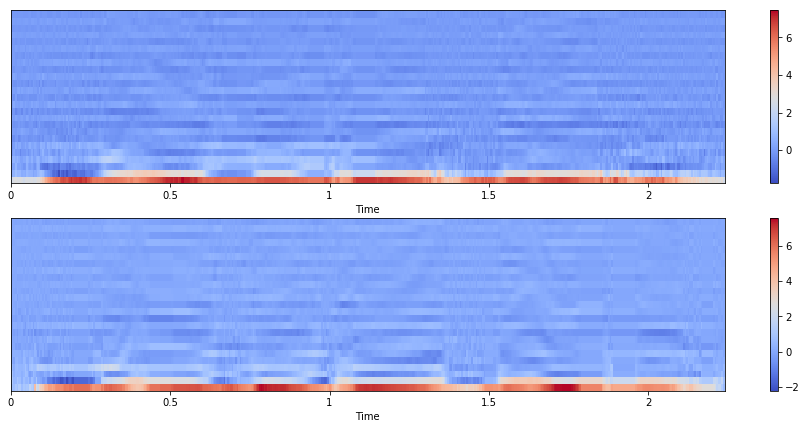

In [10]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [11]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [12]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

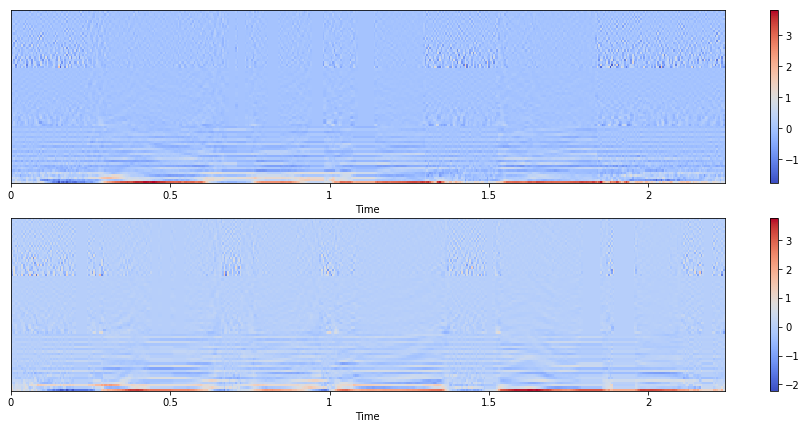

In [13]:
plot_parallel(X_aligned[idx], Y_aligned[idx])

In [14]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(349200, 144)


In [15]:
XY = remove_zeros_frames(XY)
print(XY.shape)

(192333, 144)


In [16]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=200, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
CPU times: user 2h 47min 58s, sys: 31min 37s, total: 3h 19min 36s
Wall time: 1h 25min 7s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

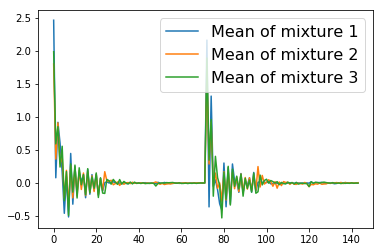

In [17]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean [CHANGE TO MU] of mixture {}".format(k+1))
legend(prop={"size": 16})

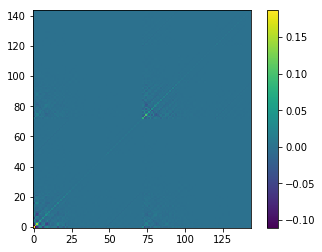

In [18]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

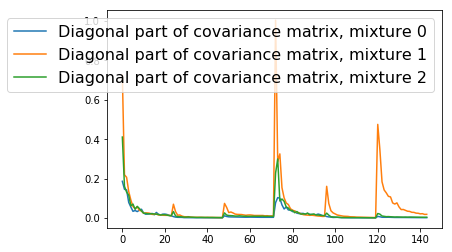

In [19]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5,
         label="Diagonal part of covariance [CHANGE TO SIGMA] matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [20]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)

    return waveform

In [21]:
for i, (src_path, tgt_path) in enumerate(zip(ksp_source.test_paths, bdl_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)

    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: arctic_a0165.wav


Target: arctic_a0165.wav


w/o MLPG


w/ MLPG


2-th sample
Source: arctic_a0201.wav


Target: arctic_a0201.wav


w/o MLPG


w/ MLPG


3-th sample
Source: arctic_a0074.wav


Target: arctic_a0074.wav


w/o MLPG


w/ MLPG


4-th sample
Source: arctic_a0164.wav


Target: arctic_a0164.wav


w/o MLPG


w/ MLPG


5-th sample
Source: arctic_a0116.wav


Target: arctic_a0116.wav


w/o MLPG


w/ MLPG


6-th sample
Source: arctic_a0276.wav


Target: arctic_a0276.wav


w/o MLPG


w/ MLPG


7-th sample
Source: arctic_a0263.wav


Target: arctic_a0263.wav


w/o MLPG


w/ MLPG


8-th sample
Source: arctic_a0166.wav


Target: arctic_a0166.wav


w/o MLPG


w/ MLPG


9-th sample
Source: arctic_a0223.wav


Target: arctic_a0223.wav


w/o MLPG


w/ MLPG
